In [1]:
"""
====================================================================================================
สรุปภาพรวม: LANDSLIDE DETECTION PIPELINE (Advanced XGBoost + GridSearch)
====================================================================================================

โค้ดนี้คือระบบสร้างโมเดล AI ทำนายดินถล่มแบบครบวงจร (End-to-End) ที่มีความซับซ้อนสูง 
โดยเน้นการดึงประสิทธิภาพสูงสุดจากข้อมูลที่มี และใช้ AI หลายตัวทำงานร่วมกัน (Hybrid Approach)

ขั้นตอนการทำงานหลัก (Step-by-Step):

1.  **Configuration (การตั้งค่า):**
    -   กำหนด Path ข้อมูล, Path โมเดลช่วย (ISO/LSTM), และไฟล์ Output
    -   กำหนดพารามิเตอร์ Grid Search (ช่วงค่าที่จะให้ AI ลองสุ่มหาค่าที่ดีที่สุด)

2.  **Data Loading (โหลดและรวมข้อมูล):**
    -   ใช้ `glob` กวาดหาไฟล์ .csv ทั้งหมดในโฟลเดอร์
    -   ทำความสะอาดชื่อ Column ให้ตรงกัน (Standardize)
    -   รวมไฟล์ทั้งหมดเป็น DataFrame เดียว (Merge)

3.  **Advanced Feature Engineering (สร้างฟีเจอร์อัจฉริยะ):**
    -   **Physics Features:** สร้างตัวแปรทางกายภาพ เช่น ฝนสะสม 24 ชม., อัตราการเปลี่ยนความชื้นดิน
    -   **Hybrid AI Features:** โหลดโมเดล Isolation Forest และ LSTM Autoencoder ที่เทรนไว้แล้ว 
        มาช่วย "ให้คะแนนความผิดปกติ" (Anomaly Score) แล้วเอาคะแนนนั้นมาเป็น Feature ใหม่ให้ XGBoost เรียนรู้

4.  **Data Transformation (แปลงร่างข้อมูล):**
    -   **Flattening (Windowing):** เนื่องจาก XGBoost รับข้อมูลเป็นกราฟ (Time Series) ไม่ได้ 
        จึงต้องแปลงข้อมูลย้อนหลัง 30 นาที (30 แถว) ให้กลายเป็น 1 แถวยาวๆ (Flatten) 
        (เช่น rain_t-0, rain_t-1 ... rain_t-29)

5.  **Data Preparation (เตรียมสอน):**
    -   **Split:** แบ่งข้อมูลเป็น Train (เรียน), Val (สอบย่อย), Test (สอบจริง)
    -   **Oversampling:** ปั๊มข้อมูลคลาส "ดินถล่ม" (Critical) ในชุด Train ให้เยอะขึ้น เพื่อแก้ปัญหาข้อมูลไม่สมดุล (Imbalance)
    -   **Scaling:** ปรับสเกลข้อมูลด้วย StandardScaler ให้เป็นมาตรฐานเดียวกัน

6.  **Model Tuning & Training (จูนและเทรน):**
    -   ใช้ **GridSearchCV** ลองผิดลองถูกหา Hyperparameter ที่ดีที่สุด (เช่น ความลึกต้นไม้, อัตราการเรียนรู้)
    -   วัดผลด้วย F1-Weighted เพื่อหาโมเดลที่สมดุลที่สุด

7.  **Evaluation (วัดผล):**
    -   นำโมเดลที่ดีที่สุดมาทดสอบกับ Val Set และ Test Set
    -   แสดงค่า Accuracy, F1-Score (Weighted/Macro), Confusion Matrix
    -   **Feature Importance Plot:** วาดกราฟดูว่าปัจจัยไหน (ฝน, ดิน, หรือคะแนนจาก AI) มีผลต่อการทำนายมากที่สุด

====================================================================================================
"""

'\n====================================================================================================\nสรุปภาพรวม: LANDSLIDE DETECTION PIPELINE (Advanced XGBoost + GridSearch)\n====================================================================================================\n\nโค้ดนี้คือระบบสร้างโมเดล AI ทำนายดินถล่มแบบครบวงจร (End-to-End) ที่มีความซับซ้อนสูง \nโดยเน้นการดึงประสิทธิภาพสูงสุดจากข้อมูลที่มี และใช้ AI หลายตัวทำงานร่วมกัน (Hybrid Approach)\n\nขั้นตอนการทำงานหลัก (Step-by-Step):\n\n1.  **Configuration (การตั้งค่า):**\n    -   กำหนด Path ข้อมูล, Path โมเดลช่วย (ISO/LSTM), และไฟล์ Output\n    -   กำหนดพารามิเตอร์ Grid Search (ช่วงค่าที่จะให้ AI ลองสุ่มหาค่าที่ดีที่สุด)\n\n2.  **Data Loading (โหลดและรวมข้อมูล):**\n    -   ใช้ `glob` กวาดหาไฟล์ .csv ทั้งหมดในโฟลเดอร์\n    -   ทำความสะอาดชื่อ Column ให้ตรงกัน (Standardize)\n    -   รวมไฟล์ทั้งหมดเป็น DataFrame เดียว (Merge)\n\n3.  **Advanced Feature Engineering (สร้างฟีเจอร์อัจฉริยะ):**\n    -   **Physics Features:** สร้างต

In [2]:
# ====================================================================
# 1. IMPORTS & CONFIGURATION
# ====================================================================
import os
import glob
import re
import random
import joblib
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from xgboost import XGBClassifier

# Load AI Models
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

class Config:
    # --- PATHS ---
    DATA_DIR = "./data/" 
    
    # Pre-trained Models
    ISO_MODEL_PATH = './../IsalationForest/model/iso_model2.joblib'
    ISO_SCALER_PATH = './../IsalationForest/model/iso_scaler2.joblib'
    LSTM_MODEL_PATH = './../LSTM_Autoencoders/lstm_autoencoder_model_fit.h5'
    LSTM_SCALER_PATH = './../LSTM_Autoencoders/scaler_fit.save'
    
    # Outputs
    OUTPUT_MODEL = "best_xgboost_model.json"
    OUTPUT_SCALER = "best_xgboost_scaler.save"
    
    # --- DATA SETTINGS ---
    SEQUENCE_LENGTH = 30
    TEST_SIZE = 0.15
    VAL_SIZE  = 0.15
    OVERSAMPLE_TARGET = 5000
    
    RAW_COLS = ['rain', 'soil', 'temp', 'humi', 'geo']
    LABEL_COL = 'label'
    LABEL_MAP = {'normal': 0, 'warning': 1, 'critical': 2}
    
    # --- GRID SEARCH SPACE ---
    # ตารางค่าพารามิเตอร์ที่จะให้ AI ลองสุ่มหา (ปรับลดเพิ่มได้)
    PARAM_GRID = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [4, 6, 8],
        'subsample': [0.7, 0.8],
        'colsample_bytree': [0.7, 0.8]
    }
    
    # Fixed Params (ค่าคงที่)
    XGB_FIXED_PARAMS = {
        'objective': 'multi:softprob',
        'num_class': 3,
        'n_jobs': -1,
        'random_state': 42,
        'tree_method': 'hist' # ใช้ hist จะเร็วขึ้นมากตอนทำ GridSearch
    }

cfg = Config()
np.random.seed(42); random.seed(42)
print("✅ Configuration Loaded")

✅ Configuration Loaded


In [3]:
# ====================================================================
# 2. UTILS & DATA LOADING
# ====================================================================
def log(msg):
    print(f"[INFO] {time.strftime('%H:%M:%S')} - {msg}")

def load_data():
    log("Loading raw CSV files...")
    all_files = glob.glob(os.path.join(cfg.DATA_DIR, "*.csv"))
    if not all_files: raise FileNotFoundError("No CSV files found.")
    
    df_list = []
    for f in all_files:
        try:
            df = pd.read_csv(f)
            # Clean columns
            df.columns = [str(c).lower().strip().replace('.1', '') for c in df.columns]
            rename_map = {'temperature':'temp', 'hum':'humi', 'humidity':'humi',
                          'devid': 'devID', 'deviceid': 'devID', 'device': 'devID',
                          'time': 'timestamp', 'date': 'timestamp'}
            new_cols = {c: rename_map[c] for c in df.columns if c in rename_map}
            if new_cols: df = df.rename(columns=new_cols)
            
            if 'devID' in df.columns:
                df['devID'] = df['devID'].astype(str).apply(lambda x: int(re.search(r'(\d+)', x).group(1)) if re.search(r'(\d+)', x) else 0)
            if 'timestamp' in df.columns:
                df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
            
            for c in cfg.RAW_COLS:
                if c not in df.columns: df[c] = 0.0
                
            df_list.append(df)
            print(f"   -> Loaded: {os.path.basename(f)} ({len(df)} rows)")
        except Exception as e:
            print(f"   ❌ Error: {e}")
            
    return pd.concat(df_list, ignore_index=True)

df_raw = load_data()
log(f"Total Data Rows: {len(df_raw)}")

[INFO] 14:07:51 - Loading raw CSV files...
   -> Loaded: final_moving_avg_devID109_test_prepared.csv (2535 rows)
   -> Loaded: label_for_dev109_test_prepared copy.csv (6566 rows)
   -> Loaded: moving_avg_for_train_prepared.csv (18222 rows)
[INFO] 14:07:51 - Total Data Rows: 27323


In [4]:
# ====================================================================
# 3. ADVANCED FEATURE ENGINEERING
# ====================================================================
def create_sequences(data, seq_len):
    Xs = []
    for i in range(len(data) - seq_len + 1):
        Xs.append(data[i : i + seq_len])
    return np.array(Xs)

def generate_features(df):
    log("Starting Feature Engineering...")
    
    # --- A. Physics Features ---
    log("   -> Generating Physics Features (Rain/Soil)...")
    df = df.sort_values(['devID', 'timestamp']).reset_index(drop=True)
    df_list = []
    for dev, g in df.groupby('devID'):
        g = g.set_index('timestamp')
        g = g[~g.index.duplicated(keep='first')]
        if len(g) > 0: g = g.resample('1T').asfreq()
        g[cfg.RAW_COLS] = g[cfg.RAW_COLS].interpolate(limit_direction='both').fillna(0)
        
        g['feat_rain_cum_24h'] = g['rain'].rolling(1440, min_periods=1).sum()
        g['feat_soil_rate']    = g['soil'].diff().fillna(0)
        g['feat_geo_abs']      = g['geo'].abs()
        
        if cfg.LABEL_COL in g.columns:
            g[cfg.LABEL_COL] = g[cfg.LABEL_COL].fillna('normal').astype(str).str.lower().str.strip()
            g[cfg.LABEL_COL] = g[cfg.LABEL_COL].map(cfg.LABEL_MAP).fillna(0).astype(int)
        else:
            g[cfg.LABEL_COL] = 0
        g['devID'] = dev
        df_list.append(g.reset_index())
    df = pd.concat(df_list, ignore_index=True)

    # --- B. AI Features (Isolation Forest) ---
    log("   -> Generating Isolation Forest Scores...")
    try:
        iso_model = joblib.load(cfg.ISO_MODEL_PATH)
        iso_scaler = joblib.load(cfg.ISO_SCALER_PATH)
        X_iso = iso_scaler.transform(df[cfg.RAW_COLS].values)
        df['feat_iso_score'] = iso_model.decision_function(X_iso)
    except Exception as e:
        print(f"      ⚠ Skip ISO features: {e}")
        df['feat_iso_score'] = 0.0

    # --- C. AI Features (LSTM Autoencoder) ---
    log("   -> Generating LSTM Reconstruction Errors...")
    try:
        lstm_model = load_model(cfg.LSTM_MODEL_PATH, compile=False)
        lstm_scaler = joblib.load(cfg.LSTM_SCALER_PATH)
        df['feat_lstm_error'] = 0.0
        lstm_results = []
        for dev, group in df.groupby('devID'):
            group = group.copy()
            X_lstm = lstm_scaler.transform(group[cfg.RAW_COLS].values)
            if len(group) >= cfg.SEQUENCE_LENGTH:
                X_seq = create_sequences(X_lstm, cfg.SEQUENCE_LENGTH)
                X_pred = lstm_model.predict(X_seq, verbose=0)
                mse = np.mean(np.power(X_seq - X_pred, 2), axis=(1, 2))
                valid_indices = group.index[cfg.SEQUENCE_LENGTH - 1:]
                group.loc[valid_indices, 'feat_lstm_error'] = mse
            lstm_results.append(group)
        df = pd.concat(lstm_results).sort_index()
    except Exception as e:
        print(f"      ⚠ Skip LSTM features: {e}")
        df['feat_lstm_error'] = 0.0

    df = df.fillna(0)
    feature_cols = cfg.RAW_COLS + [c for c in df.columns if c.startswith('feat_')]
    log(f"Feature Engineering Complete. Total Features: {len(feature_cols)}")
    return df, feature_cols

df_proc, feature_list = generate_features(df_raw)

[INFO] 14:07:51 - Starting Feature Engineering...
[INFO] 14:07:51 -    -> Generating Physics Features (Rain/Soil)...
[INFO] 14:07:51 -    -> Generating Isolation Forest Scores...
[INFO] 14:07:51 -    -> Generating LSTM Reconstruction Errors...
[INFO] 14:08:00 - Feature Engineering Complete. Total Features: 10


In [5]:
# ====================================================================
# 4. FLATTENING & SPLITTING
# ====================================================================
def flatten_data(df, features):
    log("Flattening Time Series (Windowing 30 -> 1)...")
    Xs, ys = [], []
    flat_cols = []
    for i in range(cfg.SEQUENCE_LENGTH):
        for f in features:
            flat_cols.append(f"{f}_t-{cfg.SEQUENCE_LENGTH-1-i}")
            
    for dev, g in df.groupby('devID'):
        data = g[features].values
        labels = g[cfg.LABEL_COL].values
        if len(g) < cfg.SEQUENCE_LENGTH: continue
        for i in range(len(g) - cfg.SEQUENCE_LENGTH + 1):
            window = data[i : i+cfg.SEQUENCE_LENGTH]
            Xs.append(window.flatten())
            ys.append(labels[i+cfg.SEQUENCE_LENGTH-1])
            
    return np.array(Xs), np.array(ys), flat_cols

X, y, feature_names = flatten_data(df_proc, feature_list)
log(f"Dataset Shape: {X.shape}")

# Split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=cfg.TEST_SIZE, stratify=y, random_state=42)
val_ratio = cfg.VAL_SIZE / (1.0 - cfg.TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_ratio, stratify=y_temp, random_state=42)

log(f"Split Counts -> Train: {len(y_train)}, Val: {len(y_val)}, Test: {len(y_test)}")

[INFO] 14:08:00 - Flattening Time Series (Windowing 30 -> 1)...
[INFO] 14:08:00 - Dataset Shape: (12442, 300)
[INFO] 14:08:00 - Split Counts -> Train: 8708, Val: 1867, Test: 1867


In [6]:
# ====================================================================
# 5. BALANCING & SCALING
# ====================================================================
log("Balancing Train Data (Oversampling)...")
X_res, y_res = [], []
for cls in np.unique(y_train):
    idx = np.where(y_train == cls)[0]
    chosen = np.random.choice(idx, cfg.OVERSAMPLE_TARGET, replace=True)
    X_res.append(X_train[chosen])
    y_res.append(y_train[chosen])
X_train_bal = np.concatenate(X_res)
y_train_bal = np.concatenate(y_res)

log("Scaling Data...")
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_bal)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)
joblib.dump(scaler, cfg.OUTPUT_SCALER)
log("✅ Data Prepared for Training")

[INFO] 14:08:00 - Balancing Train Data (Oversampling)...
[INFO] 14:08:00 - Scaling Data...
[INFO] 14:08:00 - ✅ Data Prepared for Training


In [7]:
# ====================================================================
# 6. HYPERPARAMETER TUNING (GRID SEARCH)
# ====================================================================
log("🚀 Starting GridSearchCV (This may take a while)...")

xgb_base = XGBClassifier(**cfg.XGB_FIXED_PARAMS)

# Create Grid Search Object
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=cfg.PARAM_GRID,
    scoring='f1_weighted', # เน้น F1-Score ภาพรวม
    cv=3,                  # แบ่ง Cross Validation 3 ส่วน
    verbose=1,
    n_jobs=-1              # ใช้ CPU เต็มสูบ
)

# Fit on Train Data (Using Val for implicit checking via CV)
grid_search.fit(X_train_s, y_train_bal)

log("✅ Grid Search Complete!")
print(f"Best Params: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")

# Get best model
best_model = grid_search.best_estimator_
best_model.save_model(cfg.OUTPUT_MODEL)
log(f"Saved Best Model to {cfg.OUTPUT_MODEL}")

[INFO] 14:08:00 - 🚀 Starting GridSearchCV (This may take a while)...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
[INFO] 14:23:24 - ✅ Grid Search Complete!
Best Params: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300, 'subsample': 0.8}
Best CV Score: 0.9960
[INFO] 14:23:24 - Saved Best Model to best_xgboost_model.json


In [8]:
# ====================================================================
# 7. FINAL EVALUATION
# ====================================================================
def evaluate_model(name, X, y_true):
    print(f"\n{'='*20} {name} RESULTS {'='*20}")
    y_pred = best_model.predict(X)
    
    # Metrics
    acc = accuracy_score(y_true, y_pred)
    f1_w = f1_score(y_true, y_pred, average='weighted')
    f1_m = f1_score(y_true, y_pred, average='macro')
    
    print(f"Accuracy    : {acc:.4f}")
    print(f"F1-Weighted : {f1_w:.4f}")
    print(f"F1-Macro    : {f1_m:.4f}")
    
    print("\n--- Confusion Matrix ---")
    print(confusion_matrix(y_true, y_pred))
    
    print("\n--- Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Warning', 'Critical']))

# Evaluate on Val and Test
evaluate_model("VALIDATION SET", X_val_s, y_val)
evaluate_model("TEST SET", X_test_s, y_test)


==================== VALIDATION SET RESULTS ====================
Accuracy    : 0.9813
F1-Weighted : 0.9819
F1-Macro    : 0.9097

--- Confusion Matrix ---
[[1705   18    5]
 [   6   75    2]
 [   0    4   52]]

--- Classification Report ---
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99      1728
     Warning       0.77      0.90      0.83        83
    Critical       0.88      0.93      0.90        56

    accuracy                           0.98      1867
   macro avg       0.88      0.94      0.91      1867
weighted avg       0.98      0.98      0.98      1867


==================== TEST SET RESULTS ====================
Accuracy    : 0.9775
F1-Weighted : 0.9787
F1-Macro    : 0.9040

--- Confusion Matrix ---
[[1698   28    2]
 [   7   72    3]
 [   0    2   55]]

--- Classification Report ---
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99      1728
     Warning       0.71      0.88 

[INFO] 14:23:24 - Generating Feature Importance Plot...


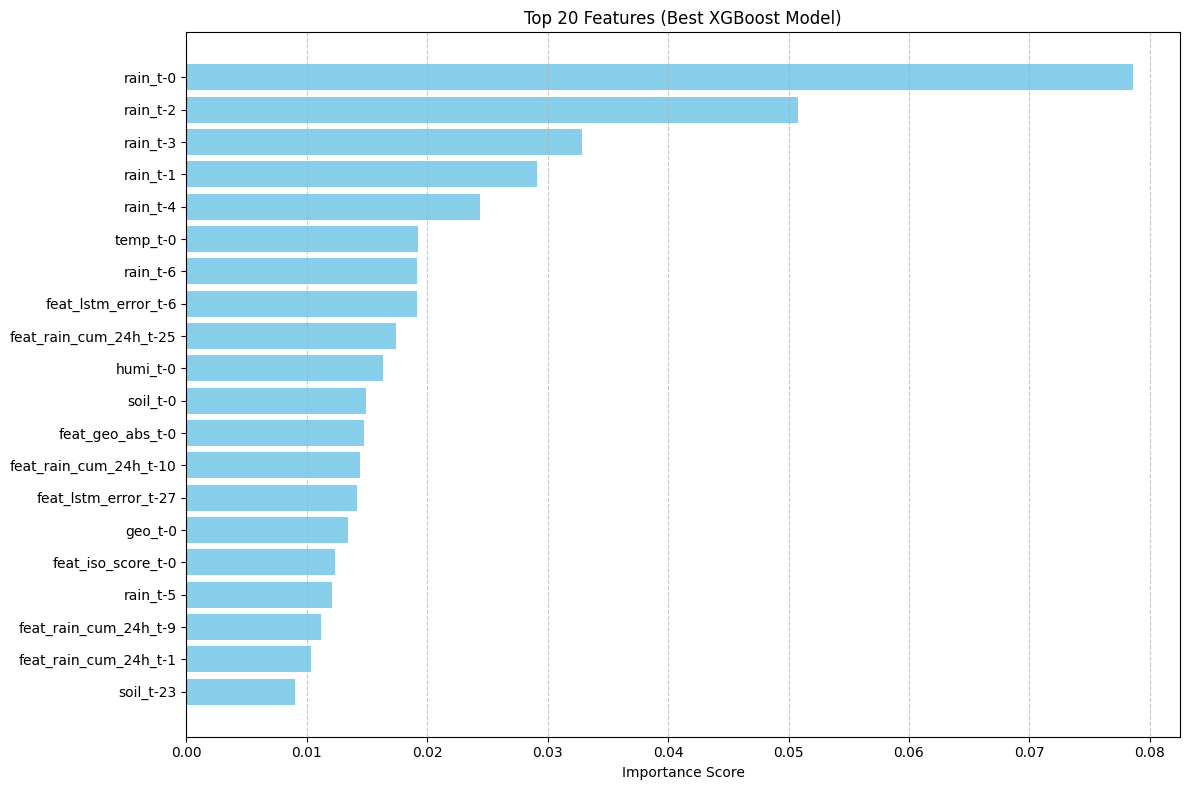

In [9]:
# ====================================================================
# 8. FEATURE IMPORTANCE PLOT
# ====================================================================
log("Generating Feature Importance Plot...")
imp = best_model.feature_importances_
indices = np.argsort(imp)[::-1][:20] # Top 20

plt.figure(figsize=(12, 8))
plt.title("Top 20 Features (Best XGBoost Model)")
plt.barh(range(20), imp[indices], align="center", color='skyblue')
plt.yticks(range(20), [feature_names[i] for i in indices])
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()